In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from sentence_transformers import SentenceTransformer, util

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import networkx as nx


In [3]:
df = pd.read_csv('IMDB_movie_details.csv')
df.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis,title
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"['Action', 'Thriller']",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",Giochi di potere
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,['Comedy'],6.6,2013-11-01,Four boys around the age of 10 are friends in ...,Last Vegas
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"['Comedy', 'Romance']",6.7,2002-04-11,NaN,Wet Hot American Summer
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"['Adventure', 'Drama', 'Western']",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...,Il tesoro della Sierra Madre
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"['Comedy', 'Drama', 'Romance']",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...,Election


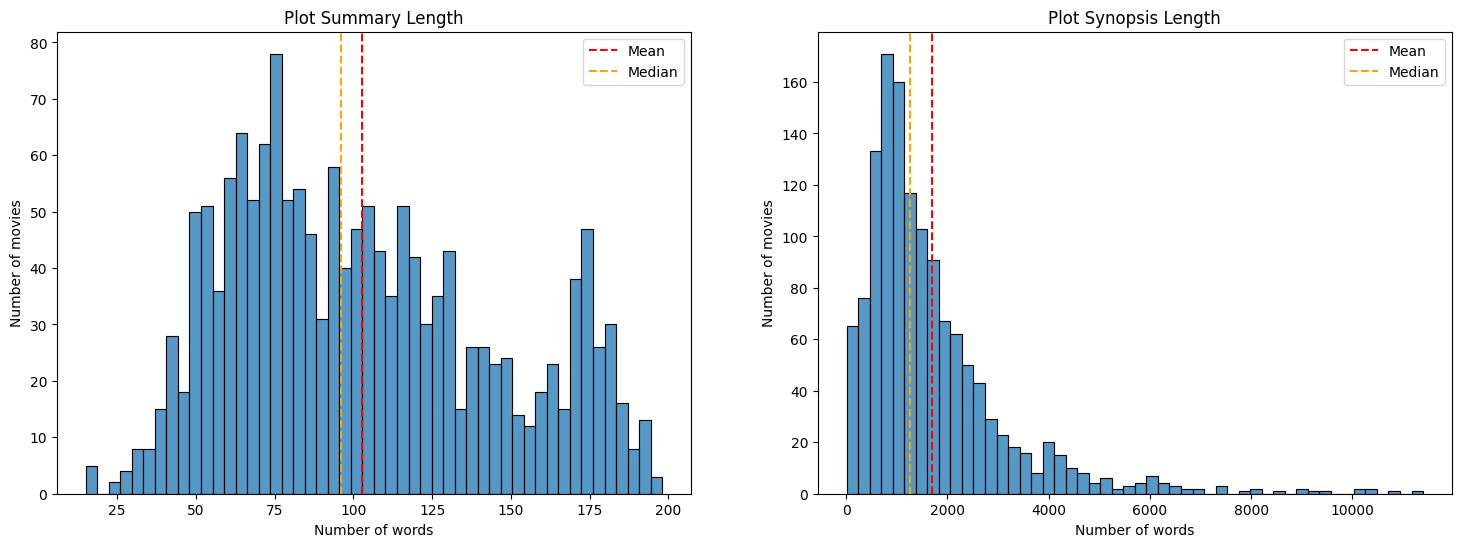

In [3]:
# plot average length of plot summary and synopsis
df['plot_summary_len'] = df.plot_summary.apply(lambda x: len(x.split()))
mov_temp = df[df.plot_synopsis.apply(lambda x: type(x) == str)].copy()
mov_temp['plot_synopsis_len'] = mov_temp.plot_synopsis.apply(lambda x: len(x.split()))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(df['plot_summary_len'], bins=50, ax=ax[0])
#put vertical line on the mean and median and show their values in the legend
ax[0].axvline(df['plot_summary_len'].mean(), color='red', linestyle='--', label='Mean')
ax[0].axvline(df['plot_summary_len'].median(), color='orange', linestyle='--')
ax[0].set_title('Plot Summary Length')
ax[0].set_xlabel('Number of words')
ax[0].set_ylabel('Number of movies')
ax[0].legend({'Mean':df['plot_summary_len'].mean(),'Median':df['plot_summary_len'].median()})

sns.histplot(mov_temp['plot_synopsis_len'], bins=50, ax=ax[1])
ax[1].axvline(mov_temp['plot_synopsis_len'].mean(), color='red', linestyle='--')
ax[1].axvline(mov_temp['plot_synopsis_len'].median(), color='orange', linestyle='--')
ax[1].set_title('Plot Synopsis Length')
ax[1].set_xlabel('Number of words')
ax[1].set_ylabel('Number of movies')
ax[1].legend({'Mean':mov_temp['plot_synopsis_len'].mean(),'Median':mov_temp['plot_synopsis_len'].median()})
plt.show()

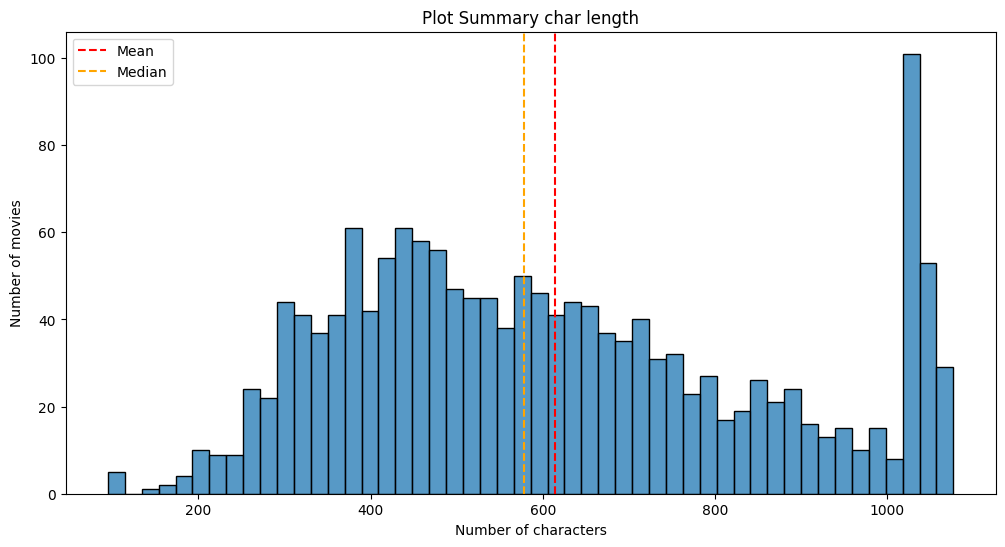

In [4]:
text_len = pd.DataFrame(columns = ['text_length_words', 'text_length_chars'])

text_len['text_length_chars'] = df['plot_summary'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(text_len['text_length_chars'], bins=50)
plt.title('Plot Summary char length')
plt.xlabel('Number of characters')
plt.ylabel('Number of movies')
plt.axvline(text_len['text_length_chars'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(text_len['text_length_chars'].median(), color='orange', linestyle='--', label='Median')
plt.legend()
plt.show()

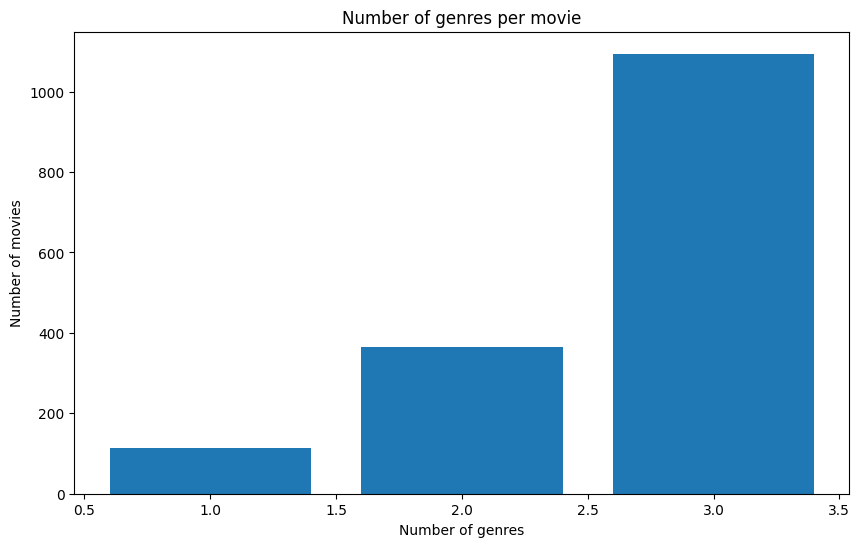

In [5]:
# get the # genres per movie
df['genre'] = df['genre'].str.split(',')
gen_len =  df['genre'].apply(lambda x: len(x))
gen_lens = dict(gen_len.value_counts())
#plot the content of this dictionary
plt.figure(figsize=(10,6))
plt.bar(gen_lens.keys(), gen_lens.values())
plt.title('Number of genres per movie')
plt.xlabel('Number of genres')
plt.ylabel('Number of movies')
plt.show()

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocessing(corpus): #revise this
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    corpus = re.sub(r'[^\w\s]', '', corpus)
    tokens = word_tokenize(corpus)
    tokens = [word.lower() for word in tokens]
    tokens = [word.replace(',' , '') for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return [''.join(token) for token in tokens]

df['processed'] = df.plot_summary.astype(str).apply(lambda x: preprocessing(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gigimancinelli./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df.processed = df.processed.apply(lambda x: ' '.join(x))
df.processed.head()

0    former cia analyst jack ryan england family va...
1    billy michael douglas paddy robert de niro arc...
2    setting camp firewood year 1981 last day every...
3    fred c dobbs bob curtin luck tampico mexico 19...
4    tracy flick running unopposed year high school...
Name: processed, dtype: object

In [8]:
def embed_text():

  if not os.path.exists('../embedding_cache_path.npy'):
    print('Start calculating embeddings...')
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    print(f'... using {model}')
    embeddings = model.encode(df['processed'])

    np.save('embedding_cache_path.npy',embeddings)
  else:
    print('Loading existing embeddings...')
    embeddings = np.load('./embedding_cache_path.npy')
    
  return embeddings

In [9]:
embeddings = embed_text()

Start calculating embeddings...
... using SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [10]:
len(embeddings)

1572

In [11]:
df['embeddings'] = embeddings.tolist()

## Build the fully connected network according to cosine similarities

In [12]:

G = nx.Graph()

[G.add_node(index, title = row['title'], genre = row['genre'], plot_summary = row['plot_summary']) for index, row in df.iterrows()]

for index, row in df.iterrows():
    for i1, r1 in df[index+1:].iterrows():
        cosim =  util.pytorch_cos_sim(row['embeddings'] , r1['embeddings'])
        if cosim > 0.0:
            G.add_edge(index, i1, weight = float(cosim[0][0]))

#remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))


In [65]:
# Calculate mean of each node's strength (sum of connected edge weights)
strengths = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes}
# calculate mean and standard deviation of each node's strength
mean_strength = np.mean(list(strengths.values()))
std_strength = np.std(list(strengths.values()))
print(f'Mean strength: {mean_strength}, Standard deviation: {std_strength}')

Mean strength: 402.64139175517687, Standard deviation: 69.81881369729844


## Prune back the network applying different algorithms

### Naive method

In [ ]:
import networkx as nx

G = nx.Graph()

[G.add_node(index, title = row['title'], genre = row['genre'], plot_summary = row['plot_summary']) for index, row in df.iterrows()]

for index, row in df.iterrows():
    for i1, r1 in df[index+1:].iterrows():
        cosim =  util.pytorch_cos_sim(row['embeddings'] , r1['embeddings'])
        if cosim > 0.44:  # trial-error threshold chosen for edge creation
            G.add_edge(index, i1, weight = float(cosim[0][0]))

#remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))

### Convex network reduction

In [34]:
from itertools import combinations

def is_convex_subgraph(subgraph, original_graph):
    """
    Check if the subgraph is convex. A subgraph is convex if the shortest path
    between any two nodes in the subgraph is the same as in the original graph.
    """
    for u, v in combinations(subgraph.nodes, 2):
        if u in original_graph and v in original_graph:
            try:
                if nx.shortest_path_length(subgraph, u, v) != nx.shortest_path_length(original_graph, u, v):
                    return False
            except nx.NetworkXNoPath:
                return False
    return True

def all_induced_subgraphs(graph):
    """
    Generate all induced subgraphs of the graph by all non-empty subsets of nodes.
    """
    for r in range(1, len(graph.nodes()) + 1):
        for nodes in combinations(graph.nodes(), r):
            yield graph.subgraph(nodes)

def check_if_convex_network(graph):
    """
    Check if every induced subgraph is convex.
    """
    for subgraph in all_induced_subgraphs(graph):
        if not is_convex_subgraph(subgraph, graph):
            return False
    return True

# Checking convexity
print("G is convex network:", check_if_convex_network(G))


G is convex network: False


### Disparity FIltering 

In [ ]:
def disparity_filter(G, alpha=0.1):
    """
    Apply the disparity filter to the graph G with a significance level alpha.
    """
    # This will hold the edges we decide to keep
    filtered_graph = nx.Graph()

    # Calculate strength of each node (sum of connected edge weights)
    strengths = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes}

    # Iterate over all nodes
    for node in G.nodes:
        # Get neighbors and corresponding edge weights
        neighbors = G.edges(node, data='weight')
        node_strength = strengths[node]

        for node, neighbor, weight in neighbors:
            # Calculate the p-value for each edge
            if node_strength > 0:  # Avoid division by zero
                p_value = 1 - (weight / node_strength)
            else:
                p_value = 1
            # Apply the disparity filter: keep edges where p-value < alpha
            if p_value < alpha:
                # Add both nodes and the weight to the filtered graph
                filtered_graph.add_edge(node, neighbor, weight=weight)

    return filtered_graph


# Applying the disparity filter with a default alpha value of 0.05
filtered_G = disparity_filter(G)

# Print the edges that were kept
print("Edges kept after applying the disparity filter:")
print(filtered_G.edges(data=True))


In [13]:
from scipy.stats import norm

def adjusted_disparity_filter(G, alpha=0.05):
    filtered_graph = nx.Graph()
    for node in G.nodes:
        neighbors = G.edges(node, data='weight')
        node_strength = sum(weight for _, _, weight in neighbors)
        if node_strength == 0:
            continue  # Skip if no strength to avoid division by zero

        mean = node_strength / G.degree(node)
        std_dev = np.sqrt(sum((weight - mean)**2 for _, _, weight in neighbors) / G.degree(node))
        for node, neighbor, weight in neighbors:
            z_score = (weight - mean) / std_dev if std_dev > 0 else 0
            p_value = 2 * (1 - norm.cdf(np.abs(z_score)))  # Two-tailed test

            if p_value < alpha:
                filtered_graph.add_edge(node, neighbor, weight=weight)

    return filtered_graph

filtered_G = adjusted_disparity_filter(G)

# Print the fraction of total edges that were kept
print("Fraction of total edges kept after applying the adjusted disparity filter:")
print(filtered_G.number_of_edges() / G.number_of_edges())



Fraction of total edges kept after applying the adjusted disparity filter:
0.08173205100693835


In [35]:
degrees = dict(filtered_G.degree())  # Converts DegreeView to dictionary

# Calculate the average degree
average_degree = sum(degrees.values()) / len(degrees)
print("Average Degree:", average_degree)
print("Standard Deviation:", np.std(list(degrees.values())))
print('Median Degree:', np.median(list(degrees.values())))
print("Minimum Degree:", min(degrees.values()))
print("Maximum Degree:", max(degrees.values()))


Average Degree: 127.92875318066157
Standard Deviation: 81.56185315950007
Median Degree: 104.0
Minimum Degree: 68
Maximum Degree: 831


In [26]:
degrees = dict(filtered_G.degree()) 
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
sorted_degrees

[(348, 831),
 (796, 817),
 (446, 790),
 (893, 788),
 (638, 768),
 (153, 754),
 (1569, 722),
 (790, 709),
 (248, 674),
 (620, 643),
 (40, 624),
 (164, 610),
 (1126, 604),
 (626, 593),
 (347, 561),
 (613, 553),
 (133, 542),
 (832, 526),
 (405, 496),
 (1277, 493),
 (1355, 483),
 (1257, 482),
 (1197, 479),
 (1022, 478),
 (889, 462),
 (1361, 459),
 (91, 459),
 (836, 452),
 (1219, 439),
 (187, 437),
 (1194, 430),
 (425, 422),
 (272, 399),
 (765, 398),
 (604, 390),
 (1484, 387),
 (443, 387),
 (1054, 379),
 (637, 369),
 (59, 364),
 (1486, 354),
 (417, 342),
 (817, 338),
 (157, 336),
 (849, 330),
 (372, 326),
 (683, 321),
 (1566, 315),
 (1184, 311),
 (707, 311),
 (85, 309),
 (1388, 308),
 (355, 307),
 (559, 304),
 (828, 304),
 (1156, 298),
 (1383, 297),
 (448, 295),
 (821, 290),
 (732, 290),
 (887, 288),
 (108, 283),
 (641, 283),
 (266, 282),
 (773, 278),
 (538, 275),
 (1377, 272),
 (1117, 269),
 (361, 267),
 (1014, 267),
 (432, 266),
 (1256, 264),
 (8, 263),
 (185, 259),
 (6, 256),
 (1007, 253

Text(0.5, 1.0, 'Network Graph ')

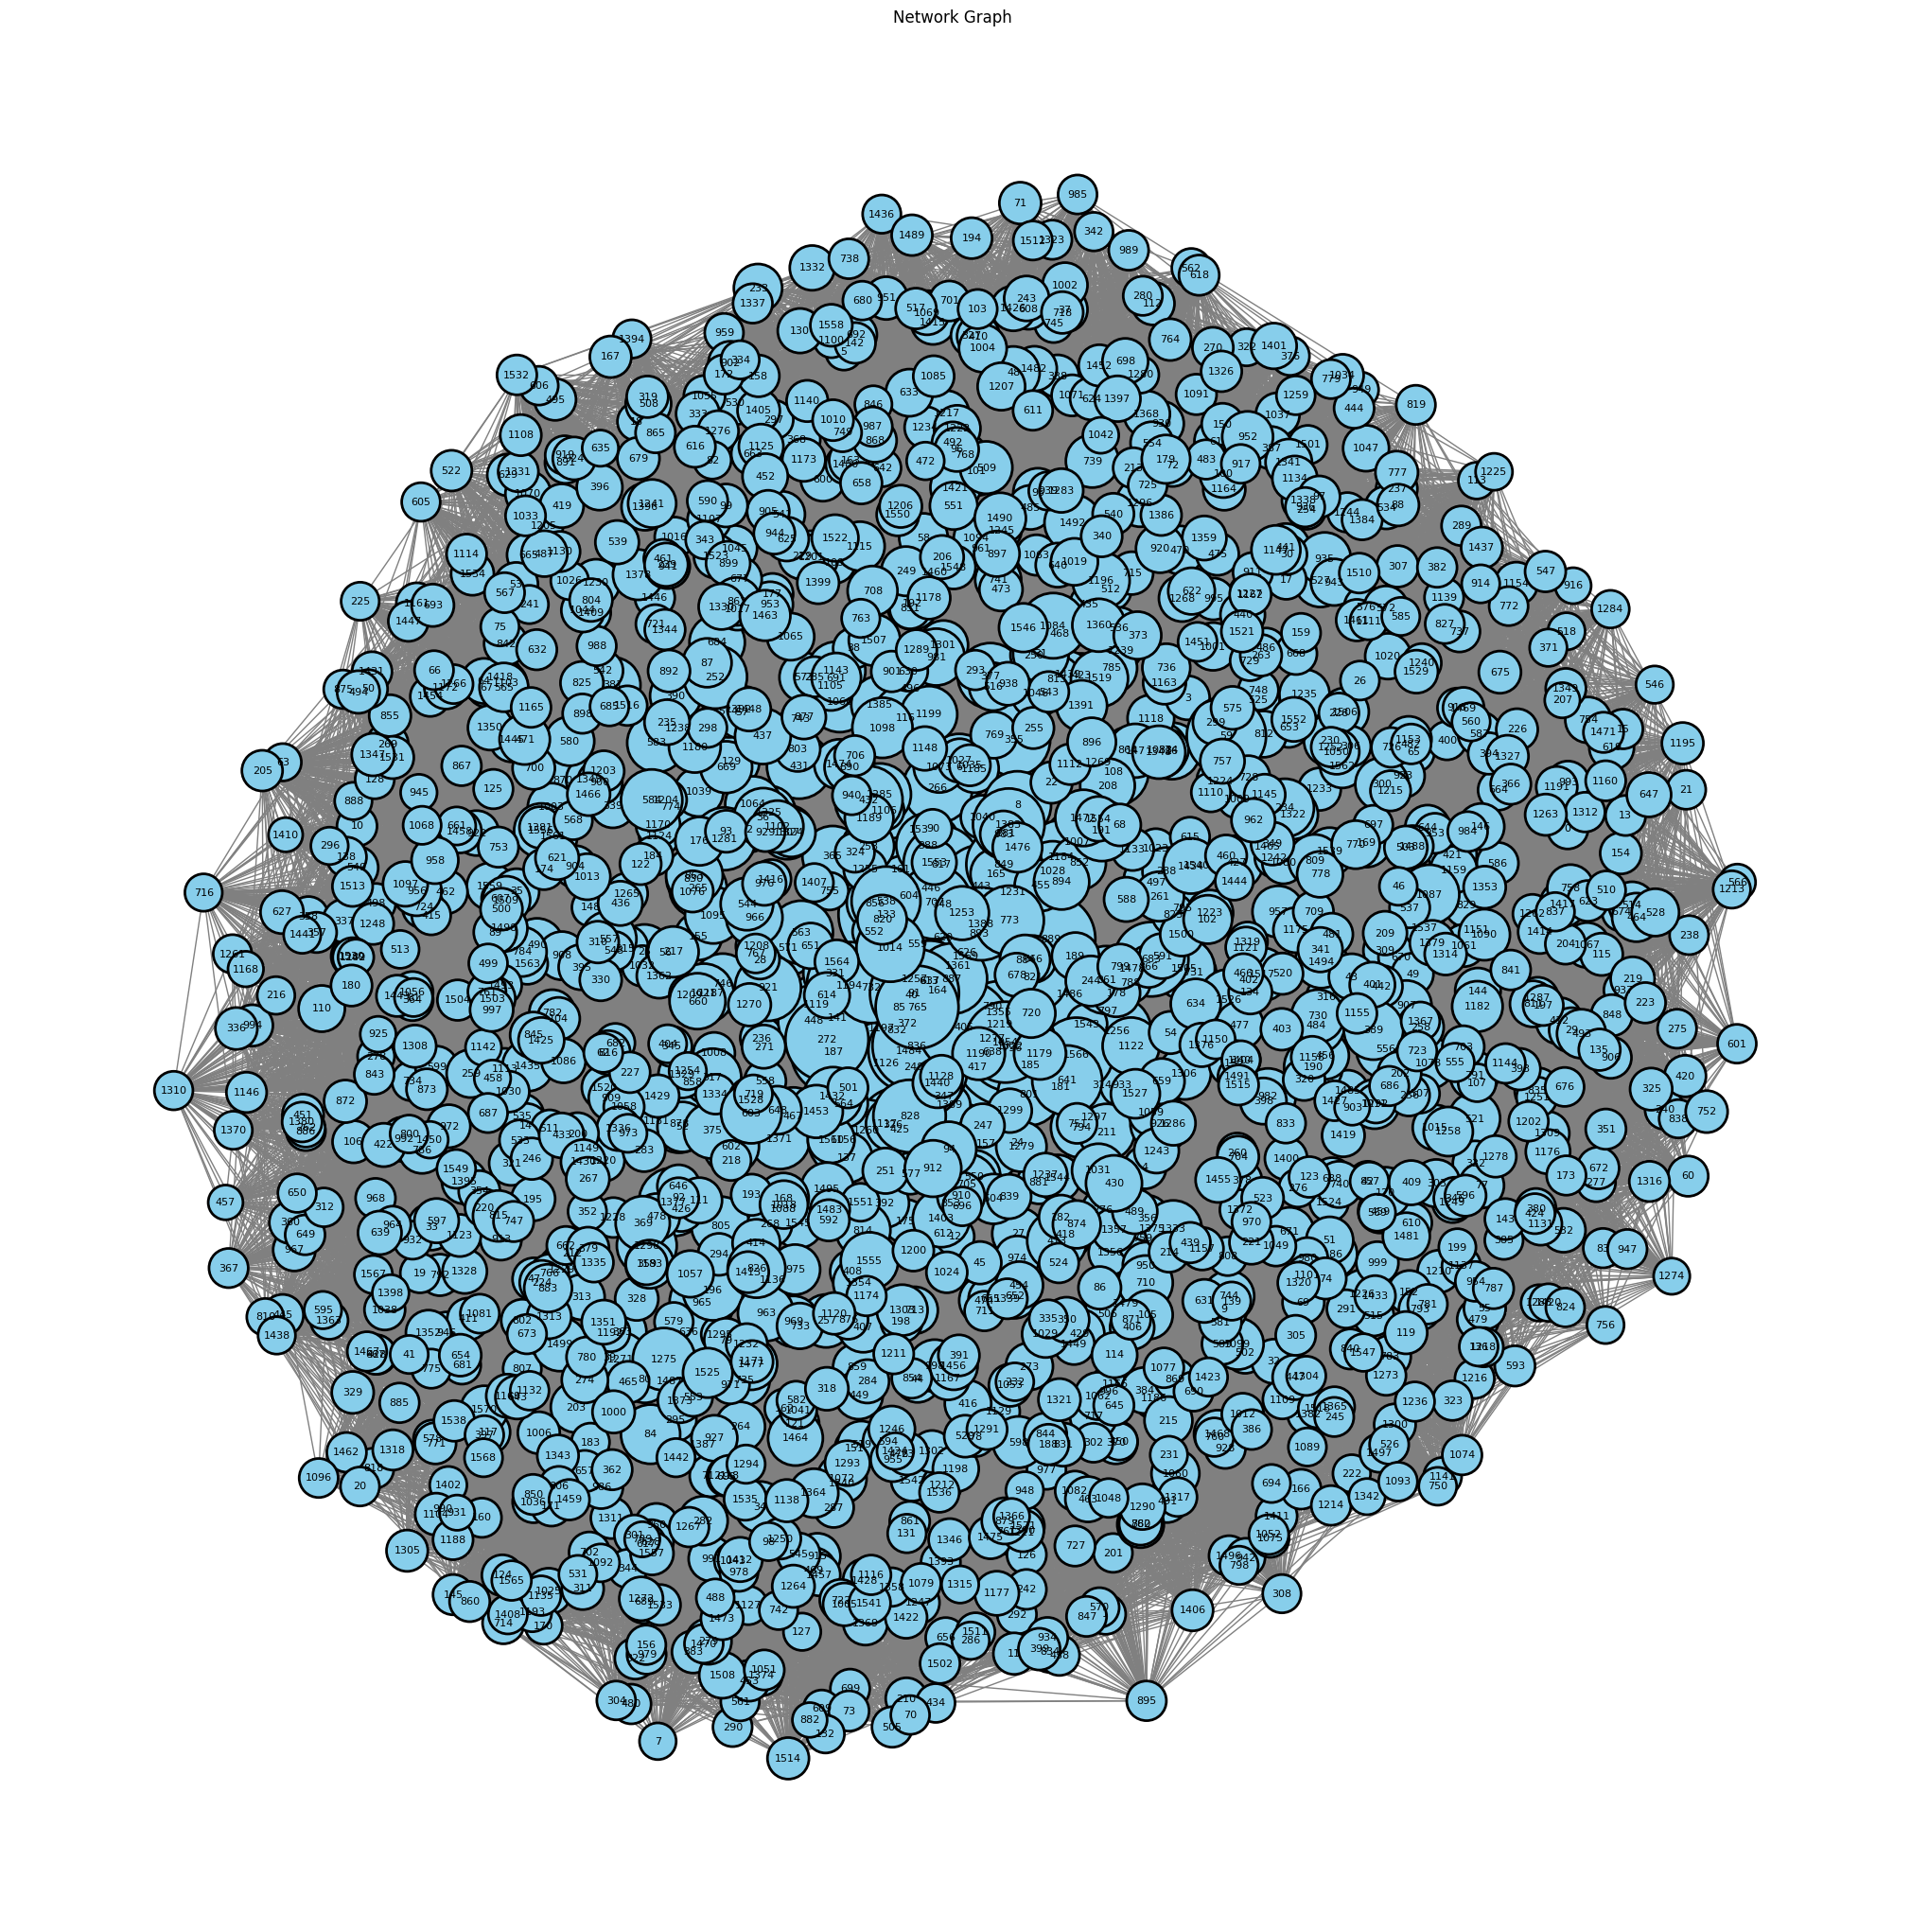

In [47]:
import matplotlib.pyplot as plt
degrees = [filtered_G.degree(n) * 10 for n in filtered_G.nodes()]  # Scale by 10 for better visualization

# Draw the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(filtered_G, seed=42)  # Seed for reproducibility 
nx.draw(filtered_G, pos, node_size=degrees, node_color='skyblue',edge_color='gray',  edgecolors='black', # skyblue fill with black borders
        linewidths=2, with_labels=True,  font_size=8)
plt.title('Network Graph ')

In [40]:
nx.write_graphml(filtered_G, "my_graph.graphml")

### Quantile method

In [53]:
all_weights = [G[u][v]['weight'] for u, v in G.edges()]
threshold = np.percentile(all_weights, 60)  # Keep top 40% of edges
print(np.mean(all_weights))
filtered_graph = nx.Graph()
for u, v, data in G.edges(data=True):
    if data['weight'] >= threshold:
        filtered_graph.add_edge(u, v, weight=data['weight'])

# Print the edges that were kept
print("Edges kept after applying the disparity filter:")
print(filtered_G.edges(data=True))


0.2572424568381819
Edges kept after applying the disparity filter:
[]


## Now we move on using Disparity filtering 

In [6]:
G = nx.read_graphml("my_graph.graphml")

In [7]:
A_d = nx.adjacency_matrix(G)
print(A_d.todense())

[[0.         0.4437179  0.03400501 ... 0.         0.         0.        ]
 [0.4437179  0.         0.         ... 0.         0.         0.        ]
 [0.03400501 0.         0.         ... 0.07072687 0.         0.        ]
 ...
 [0.         0.         0.07072687 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
A_d = nx.adjacency_matrix(G)
sns.heatmap(A_d.todense(),
            annot=True,
            cmap = 'viridis',
            xticklabels=G.nodes(),
            yticklabels=G.nodes())

In [8]:
betw_centr = dict(sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse = True))

print(betw_centr)


{'348': 0.0213923740738803, '796': 0.020410051222790312, '446': 0.01880174335330674, '893': 0.018779397042846528, '638': 0.01798805058825531, '153': 0.017303810160087117, '1569': 0.016049701960232903, '790': 0.014701661474765362, '248': 0.013754795117952327, '620': 0.012364373892378254, '40': 0.01162138481352774, '164': 0.011156475541941276, '1126': 0.011042323392509152, '626': 0.010337238827127162, '347': 0.009803202286645307, '613': 0.00896701942609558, '133': 0.008739038997461321, '832': 0.008296780519576464, '405': 0.00752476102566499, '1277': 0.007117947956942481, '1257': 0.007067366939482889, '1355': 0.007013761272571609, '1022': 0.006963128879586289, '1197': 0.00641086622073007, '91': 0.006291241640097145, '889': 0.006215684742612386, '836': 0.006069804827183656, '187': 0.005863673543303527, '1219': 0.005806292814188896, '1361': 0.005797966718804582, '425': 0.005598611970439157, '1194': 0.00558620571511312, '272': 0.004626106218615944, '765': 0.004505006398556487, '1484': 0.0043

In [9]:
close_cent = dict(sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse = True))
close_cent

{'348': 0.6797922977066205,
 '796': 0.6756989247311828,
 '446': 0.6679421768707483,
 '893': 0.667374681393373,
 '638': 0.6617523167649537,
 '153': 0.6578726968174204,
 '1569': 0.6491735537190083,
 '790': 0.64570489108097,
 '248': 0.6365478119935171,
 '620': 0.6286514605842337,
 '40': 0.6239078633836378,
 '164': 0.6204581358609794,
 '1126': 0.6189913317572892,
 '626': 0.6163201255394273,
 '347': 0.6086788066640837,
 '613': 0.6067979915025106,
 '133': 0.6042307692307692,
 '832': 0.6005351681957186,
 '405': 0.5937263794406652,
 '1277': 0.5930539826349566,
 '1355': 0.5908236179014668,
 '1257': 0.5906015037593985,
 '1197': 0.5899361622230567,
 '1022': 0.5897147147147147,
 '889': 0.5861940298507463,
 '1361': 0.5855385762206485,
 '91': 0.5855385762206485,
 '836': 0.5840148698884758,
 '1219': 0.5812060673325934,
 '187': 0.5807763401109057,
 '1194': 0.5792772861356932,
 '425': 0.5775735294117647,
 '272': 0.5727305869485965,
 '765': 0.5725218658892128,
 '604': 0.5708575581395349,
 '1484': 0.5702

In [10]:
# find cliques with networkx
cliques = list(nx.find_cliques(G))

cliques.sort(key=len)
cliques

[['1278', '765', '635'],
 ['1278', '765', '686'],
 ['1278', '765', '1422'],
 ['1278', '1509', '1239'],
 ['1278', '1509', '893'],
 ['1278', '1566', '1416'],
 ['1278', '1484', '759'],
 ['1278', '1344', '887'],
 ['1278', '1123', '147'],
 ['1278', '1123', '849'],
 ['1278', '1123', '347'],
 ['1278', '638', '690'],
 ['1278', '887', '1493'],
 ['1278', '887', '373'],
 ['1278', '635', '821'],
 ['1278', '1465', '1022'],
 ['1278', '893', '1416'],
 ['1278', '214', '1022'],
 ['1278', '1117', '1493'],
 ['1278', '1022', '178'],
 ['1278', '690', '91'],
 ['1278', '1422', '91'],
 ['1278', '91', '951'],
 ['32', '732', '251'],
 ['32', '1032', '1051'],
 ['32', '1032', '483'],
 ['32', '884', '438'],
 ['32', '217', '563'],
 ['32', '1197', '264'],
 ['32', '1197', '251'],
 ['32', '1197', '239'],
 ['32', '185', '888'],
 ['32', '185', '616'],
 ['32', '419', '1101'],
 ['32', '419', '865'],
 ['32', '96', '692'],
 ['32', '467', '670'],
 ['32', '467', '682'],
 ['32', '746', '715'],
 ['32', '1242', '431'],
 ['32', '4

In [13]:
from collections import defaultdict

pos = nx.spring_layout(G, seed= 42)

# sort them by length
cliques_by_len = defaultdict(list)
for clique in cliques:
    
    cliques_by_len[len(clique)].append(clique)
    
# visualize the graph with cliques
fig, ax = plt.subplots(figsize = (7,5))
colors = sns.color_palette(palette='tab20', n_colors=5).as_hex()

n = nx.draw_networkx_nodes(G,
                           pos =pos,
                           node_size = 40,
                           node_color = 'gray',
                           ax = ax
                          )
for i,(length,cliques) in enumerate(cliques_by_len.items()):
    for clique in cliques:
    
        n = nx.draw_networkx_nodes(G.subgraph(clique),
                                   pos =pos,
                                   node_color = colors[i],
                                   edgecolors = 'gray',
                                   ax = ax,
                                  )
        n = nx.draw_networkx_edges(G.subgraph(clique),
                                   pos =pos,
                                   edge_color = colors[i],
                                   width=3,
                                   alpha = .9,
                                   ax = ax,
                                  )
l = nx.draw_networkx_labels(G, pos=pos, ax = ax)
ax.axis('off')
ax.set_title('Cliques')


## Clusters as communities: Hierarchical clustering

Since every network can be represented as a matrix, such as the Adjacency matrix (or the distance matrix between nodes as you will see later), one way to detect communities in a network is to use classic clustering methods used in machine learning and statistical infernce. 

Hierarchical clustering, for instance, is a method that groups similar nodes (i.e. based on a distance measure) together in a hierarchical tree structure called a dendrogram. This hierarchical structure can be cut at a certain level to obtain clusters/communities.

To create a dendrogram of the Karate club network, we can use the SciPy library:

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial import distance


# Create the distance matrix using ... the shortest paths
path_length= dict(nx.all_pairs_shortest_path_length(G))

# now populate a distance matrix
distance_matrix = pd.DataFrame(index = range(34), columns = range(34))
for k,v in path_length.items():
    distance_matrix[k] = pd.Series(v).sort_index()
#print(distance_matrix.head())
# visualize the matrix
fig, axes = plt.subplots(1,2, figsize =(10,4))

# adjacency matrix
sns.heatmap(nx.adjacency_matrix(G).todense(), square=True, ax= axes[0], cmap = plt.cm.viridis)
axes[0].set_title('Adjacency matrix')
# distance matrix
sns.heatmap(distance_matrix, square=True, ax= axes[1], cmap = plt.get_cmap('Blues_r',5))
axes[1].set_title('Distance matrix')

plt.show()

In [ ]:
# put the distance matrix in triangular form and compute the dendrogram
Y = distance.squareform(distance_matrix)
# Compute the dendrogram wiht the average method. 
# There are also other methods available simple/complete/max/farthest point linkage 
Z = hierarchy.average(Y)

#plot the dendrogram
plt.figure(figsize=(8,5))
hierarchy.dendrogram(Z)
plt.title('Hierarchical clustering -  Dendrogram')
plt.show()

In [ ]:
# plot the adjacency matrix sorting rows and columns using the order made by the clustering

# tip: use the hierarchy.leaves_list() method
ordered_leaves = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, Y))


fig, axes = plt.subplots(2,2, figsize =(10,8))

# adjacency matrix
axes[0,0].set_title('Adjacency matrix')
sns.heatmap(nx.adjacency_matrix(G).todense(),
            square=True, 
            ax= axes[0,0],
            cmap = plt.cm.viridis)
# distance matrix
axes[0,1].set_title('Distance matrix')
sns.heatmap(distance_matrix,
            square=True,
            ax= axes[0,1],
            cmap = plt.get_cmap('Blues_r',5))

# sorted adjacency matrix
axes[1,0].set_title('Adjacency matrix - Sorted')
sns.heatmap(pd.DataFrame(nx.adjacency_matrix(G).todense()).loc[ordered_leaves,ordered_leaves],
            square=True, 
            ax= axes[1,0],
            cmap = plt.cm.viridis)
#sorted distance matrix
axes[1,1].set_title('Distance matrix - Sorted')
sns.heatmap(pd.DataFrame(distance_matrix).loc[ordered_leaves,ordered_leaves],
            square=True,
            ax= axes[1,1],
            cmap = plt.get_cmap('Blues_r',5))

plt.show()

In [ ]:
# plot the communities at diffent cuts
# set the edgecolors of the nodes according to the original club
cutree = hierarchy.cut_tree(Z,n_clusters = [1,2,3,4,5,6])


fig, axes = plt.subplots(3,2, figsize = (12,12))
axes = axes.flatten()
for i in range(len([1,2,3,4,5,6])):
    
    #partition
    partition = [float(n) for n in cutree[:,i].reshape(1,-1)[0]]
    #nodes
    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_color= partition,
                           linewidths= 2,
                           cmap=plt.cm.tab20,
                           ax = axes[i])
    
    
    #edges and labels
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax = axes[i])
    nx.draw_networkx_labels(G, pos, ax = axes[i])
    axes[i].axis('off')
    axes[i].set_title(f'Communities: {i}')

## The Girvan-Newman Algorithm

Introduced by Girvan and Newman in 2002, in their famous paper of the community structure in social and bìiological networks \
[Girvan & Newman, (2002). Community structure in social and biological networks.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC122977/) 

This is a divisive methods, which recursively remove edges from the network to break it into smaller components. The algorithm works by computing the betweenness centrality of all edges in the network and removing the edge with the highest betweenness centrality at each step. This process is repeated until the desired number of communities is obtained or when alla nodes are separated in as many partitions.

In [ ]:
# function to remove an edge
def edge_to_remove(graph):
    e_betw = nx.edge_betweenness_centrality(graph)
    edge = ()
    
    # extract the edge with highest edge betweenness centrality score
    sorted_e_betw = sorted(e_betw.items(), key = lambda x:x[1], reverse = True)
    edge = sorted_e_betw[0][0]
    return edge

In [ ]:
def girvan_newman(graph):
        
    partitions = []

    #make copy of graph
    graph = graph.copy()

    # find number of connected components - which are the partitions- and store them in the list of partitions
    # count the number of partiions
    cc = nx.connected_components(graph)
    cc_count = nx.number_connected_components(graph)

    partitions.append(list(cc))
    
    # remove one edge at a time and re-evaluate the number of connected components
    # Hint: use while loop until every node is in a different community
    while(cc_count < len(graph)):
        graph.remove_edge(*edge_to_remove(graph)) # we remove the bridge: the edge with the highest betw. centrality
        cc = nx.connected_components(graph)
        n_comm = nx.number_connected_components(graph)

        if n_comm > cc_count: 
            partitions.append(list(cc))
        cc_count = n_comm
            
    return partitions

In [ ]:
# find communities in the graph
gn_partitions = girvan_newman(G)

In [ ]:
# visualize the adjacency matrix for only two partitions (we can extend this to more partitions)
sorted_nodes = [ j for i in gn_partitions[:2] for j in i]

fig, axes = plt.subplots(1,2, figsize =(10,4))
sns.heatmap(nx.adjacency_matrix(G).todense(), square=True, ax= axes[0], cmap = plt.cm.viridis)
axes[0].set_title('Adjacency matrix')

sns.heatmap(pd.DataFrame(nx.adjacency_matrix(G).todense()).loc[sorted_nodes, sorted_nodes],
            square=True,
            ax= axes[1],
            cmap = plt.cm.viridis)
axes[1].set_title('Adjacency matrix - Sorted')

## Modularity

Modularity measures the strength of the division of a network into partitions. 

We can see it as the fraction of the edges that lie within the same group 
minus the expected fraction if edges were distributed at random.

$ Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)\delta(c_i,c_j)$

where $m$ is the number of edges, $A$ is the adjacency matrix of `G`,
$k_i$ is the degree of $i$, $\gamma$ is the resolution parameter,
and $\delta(c_i, c_j)$ is 1 if $i$ and $j$ are in the same community else 0. 

or 

$Q = \sum_{c=1}^{n} Q_c = \sum_{c=1}^{n}\left[ \frac{L_c}{m} - \left( \frac{k_c}{2m} \right) ^2 \right]$

where the sum iterates over all communities $c$, $m$ is the number of edges,
$L_c$ is the number of intra-community links for community $c$,
$k_c$ is the sum of degrees of the nodes in community $c$,
and $\gamma$ is the resolution parameter

In [ ]:
# modularity directly with networkx 
Q = nx.community.modularity(G, gn_partitions, weight = 'weight')
Q

In [ ]:
# save the best partition for GN

gn_best_partition = gn_partitions[4]
print(nx.community.modularity(G, gn_best_partition,weight='weight'))

# store it in a pd.Series for convenience
gn_best_partition = pd.Series({node: i for i, nodes in enumerate(gn_best_partition) for node in nodes}).sort_index()

In [ ]:
# plot the adjacency matrix
sorted_nodes = gn_best_partition.sort_values().index 

fig, axes = plt.subplots(1,2, figsize =(10,4))
sns.heatmap(nx.adjacency_matrix(G).todense(), square=True, ax= axes[0], cmap = plt.cm.viridis)
axes[0].set_title('Adjacency matrix')

sns.heatmap(pd.DataFrame(nx.adjacency_matrix(G).todense()).loc[sorted_nodes, sorted_nodes],
            square=True,
            ax= axes[1],
            cmap = plt.cm.viridis)
axes[1].set_title('Adjacency matrix - Sorted')

In [ ]:
# plot the communities for GN against the original ones
# set the edgecolors of the nodes according to the original club

fig, axes = plt.subplots(1,1, figsize = (7,5))

nx.draw_networkx_nodes(G, 
                       pos, 
                       node_color= [gn_best_partition[n] for n in G],
                       linewidths= 2,
                       cmap=plt.cm.tab10,
                       ax = axes)
nx.draw_networkx_edges(G, pos, alpha=0.5, ax = axes)
nx.draw_networkx_labels(G, pos, ax = axes)
axes.axis('off')
axes.set_title(f'GN best partition')

## Louvain Algorithm

The Louvain algorithm is a greedy and agglomerative algorithm for community detection.

This algorithm greedily maximizes modularity.

Each pass is made of two phases:

Phase 1. -  Modularity is optimised by allowing only local changes to node-community membership

Phase 2. - The identified communities are aggregated into “super nodes” to build a new network


The passes are repeated iteratively until no increase in modularity is possible.

In [ ]:
%%capture
!pip install community

In [ ]:
import community
from community import community_louvain

# find partition with Louvain algorithm
louvain_partition = community_louvain.best_partition(G,weight = 'weight', random_state = 42)

In [ ]:
Q = community_louvain.modularity(louvain_partition,G,weight = 'weight')

dendro = community_louvain.generate_dendrogram(G, weight = 'weigth')


In [ ]:
# plot the network with the communities and the induced graph of supernodes

fig, axes = plt.subplots(2,2, figsize = (12,10))

for level in range(len(dendro)) :
    
    part = community_louvain.partition_at_level(dendro, level)
    mod_level = community_louvain.modularity(part, G, weight = 'weight')
        
    # graph with communities
    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_color= list(part.values()),                           linewidths= 2,
                           cmap=plt.cm.tab20,
                           ax = axes[level,0])
    nx.draw_networkx_edges(G, 
                           pos, 
                           ax = axes[level,0])
    nx.draw_networkx_labels(G, pos, ax = axes[level,0])
    
    axes[level,0].set_title(f"Communitites: {len(set(part.values()))} - Q: {round(mod_level, 3)}")
    
    # induced graph 
    ind = community_louvain.induced_graph(part, G)
    
    pos_ind = nx.spring_layout(ind, seed = 20)
    no = nx.draw_networkx_nodes(ind,
                 node_color = pd.Series(part).drop_duplicates().values,
                 cmap=plt.cm.tab20,
                 pos= pos_ind, ax =axes[level,1])
    ed = nx.draw_networkx_edges(ind, 
                   pos = pos_ind, 
                   ax = axes[level,1])
    
    # plot the edge labels
    el = nx.draw_networkx_edge_labels(ind,
                                        edge_labels = nx.get_edge_attributes(ind, 'weight'), 
                                        verticalalignment='baseline',
                                        horizontalalignment = 'left',
                                        font_size = 9,
                                        pos=pos_ind,
                                        ax = axes[level,1])
    no.set_zorder(1)
    axes[level,1].set_title(f"Induced graph")

    axes[level,1].axis('off')
    axes[level,0].axis('off')

# Final comparison 

In [ ]:
# find the best partition for the hierarchical clustering

cutree = hierarchy.cut_tree(Z)
mod_hierarchical = dict()

cutree = hierarchy.cut_tree(Z)
for i in range(cutree.shape[1]):
    part_cut  = pd.Series(cutree[:,i].reshape(1,-1)[0]).to_dict()
    mod_hierarchical[len(G) - i] = community_louvain.modularity( part_cut, G, weight = 'weight')
    
mod_hierarchical = pd.Series(mod_hierarchical)

# find the best cut
hierarchical_partition = cutree[:, mod_hierarchical.argmax()]


In [ ]:
all_partitions = pd.DataFrame()

all_partitions['Hierarchical'] =  hierarchical_partition
all_partitions['Girvan-Newman'] =  gn_best_partition
all_partitions['Louvain'] =  louvain_partition

all_partitions

In [ ]:
# evaluate mutual information 
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

ami_df = pd.DataFrame(columns = all_partitions.columns, index = all_partitions.columns)
for c1 in all_partitions: 
    for c2 in all_partitions: 
        ami_df.loc[c1,c2] = round(adjusted_mutual_info_score(all_partitions[c1], all_partitions[c2]),3)

ami_df